# Урок 4. Метрики качества классификации ч.2

Продолжим работу с метриками классификации. В предыдущем задании мы разобрали матрицу ошибок и две основные метрики, которые используются при бинарной классификации.

Сейчас рассмотрим F-меру - совокупную метрику по precision и recall - и более сложную AUC-ROC.

### 2.1
Из задания к предыдущему уроку выберите классификатор, который давал наименьшее значение recall, вычислите для него precision, применив precision_score, и самостоятельно посчитайте F1-меру (расчеты должны присутствовать). Затем проверьте ответ, используя встроенную функцию.

Сравните полученную f1-меру со значением среднего арифметического полноты и точности.

In [5]:
from sklearn.metrics import precision_score, f1_score
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, recall_score


In [14]:
### YOUR CODE HERE ###
df = pd.read_csv('titanic.csv', sep=';', header=0)
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)

prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = ((prec*recall) / (prec+recall)) *2

print(f'{gnb.__class__.__name__}: prec = {prec}, recall = {recall}, f1 = {f1}, mean pr-rec = {(prec+recall) / 2}')



GaussianNB: prec = 0.8205128205128205, recall = 0.3595505617977528, f1 = 0.5, mean pr-rec = 0.5900316911552866


В библиотеке sklearn есть удобная функция classification_report, возвращающая precision, recall, F-меру и количество экземпляров каждого класса в удобном для чтения формате. Также существует функция precision_recall_fscore_support, возвращающая те же самые метрики, но в форме массива.

### 2.2
Для каждого классификатора из предыдущего урока рассчитайте и выведите следующие импортированные метрики.

In [9]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [15]:
### YOUR CODE HERE ###

kns = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
dtc = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
lr = LogisticRegression(max_iter=10000, random_state=42).fit(X_train, y_train)

algs = [kns, gnb, dtc, lr]

for alg in algs:
    print(f'{alg.__class__.__name__}\n', classification_report(y_test, alg.predict(X_test)))


KNeighborsClassifier
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       134
           1       0.76      0.73      0.74        89

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223

GaussianNB
               precision    recall  f1-score   support

           0       0.69      0.95      0.80       134
           1       0.82      0.36      0.50        89

    accuracy                           0.71       223
   macro avg       0.76      0.65      0.65       223
weighted avg       0.74      0.71      0.68       223

DecisionTreeClassifier
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       134
           1       0.76      0.76      0.76        89

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg    

Вернемся к классификатору LogisticRegression, который мы обучали в предыдущем задании. Там мы не затрагивали настройку гиперпараметров: сделать это можно с помощью LogisticRegressionCV - перебора параметров по сетке с последующей кросс-валидацией (по сути это аналог GridSearchCV, но со своими параметрами внутри, применимыми только к логистической регрессии). Этот класс создан специально для логистической регрессии, т.к. для нее известны эффективные алгоритмы перебора параметров.

У LogisticRegression есть гиперпараметр C - обратный коэффициент регуляризации. Не вдаваясь в подробное описание по формуле, можно сказать, что C соответствует "сложности" модели: чем больше C, тем более сложные зависимости может восстанавливать модель; если параметр C слишком мал (слишком сильная регуляризация), то модель окажется недообученной, а если наоборот регуляризация слишком слабая (т.е. C принимает большие значения), то скорее всего модель окажется переобученной, потому как модель будет слишком "бояться" ошибиться на обучающей выборке.

### 2.3 

1. Используя StratifiedKFold, разбейте данные для кросс-валидации по 5-ти блокам (не забывайте во всех методах использовать random_state=17).
2. С помощью numpy.logspace разбейте интервал (-1, 2) на 500 значений.
3. С помощью LogisticRegressionCV подберите оптимальный параметр C: установите гиперпараметр Cs равным объекту из п.2 (разбиение интервала (-1, 2) отвечает за подбор обратного коэффициента регуляризации C); cv равным объекту из п.1 (разбиение для кросс-валидации); scoring равным "roc_auc" (отвечает за оптимизацию гиперпараметров на кросс-валидации: метрика, установленная в scoring, контролирует, как оценивать модель при каждом из наборе параметров, т.е. показывает, какая метрика должна быть наилучшей).
4. Обучите полученную модель на тренировочных данных.

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import matplotlib.pyplot as plt

In [18]:
### YOUR CODE HERE ###
Cs = np.logspace(-1, 2, 500)
lr = LogisticRegressionCV(max_iter=10000, Cs=Cs, cv=5, scoring='roc_auc').fit(X_train, y_train)

In [34]:
roc_auc = lr.scores_[1]
roc_auc = [np.mean(x) for x in roc_auc.reshape(500,5)]


### 2.4
Используя метод plot из matplotlib.pyplot, выведите график зависимости auc_roc от значения C.

*Примечание: значения по оси x - разбиение с помощью np.logspace из п.2 предыдущего задания, а значения по оси y - среднее значение roc_auc по каждой валидации, т.е. среднее значение из полученных на каждом из 5-ти разбиений при данном параметре C (используйте метод scores_ объекта, который инкапсулирует LogisticRegressionCV).*

In [83]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

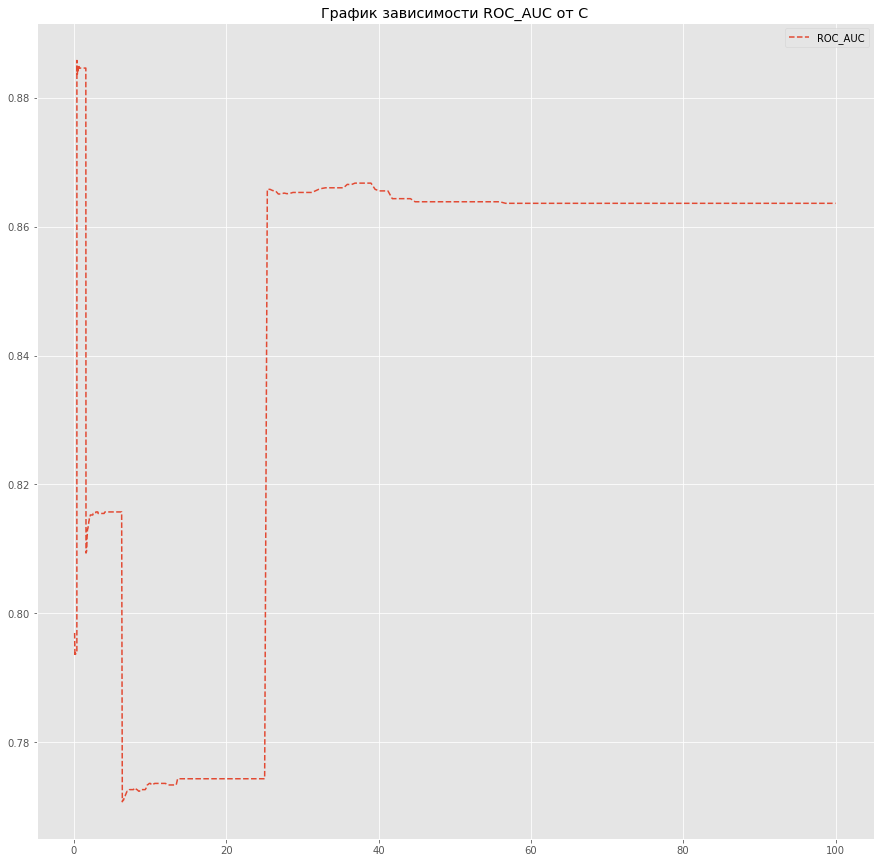

In [84]:
### YOUR CODE HERE ###
plt.figure(figsize=(15,15))
plt.plot(Cs, roc_auc, label='ROC_AUC', linestyle='--')
plt.legend()
plt.title('График зависимости ROC_AUC от C')
plt.show()



### 2.5
С помощью метода C_ того же объекта выведите лучшее значение C. Выведите более конкретную область графика (область ~15 точкам по x), включающую лучшее значение C.

*Примечание: используйте plt.xlim.*

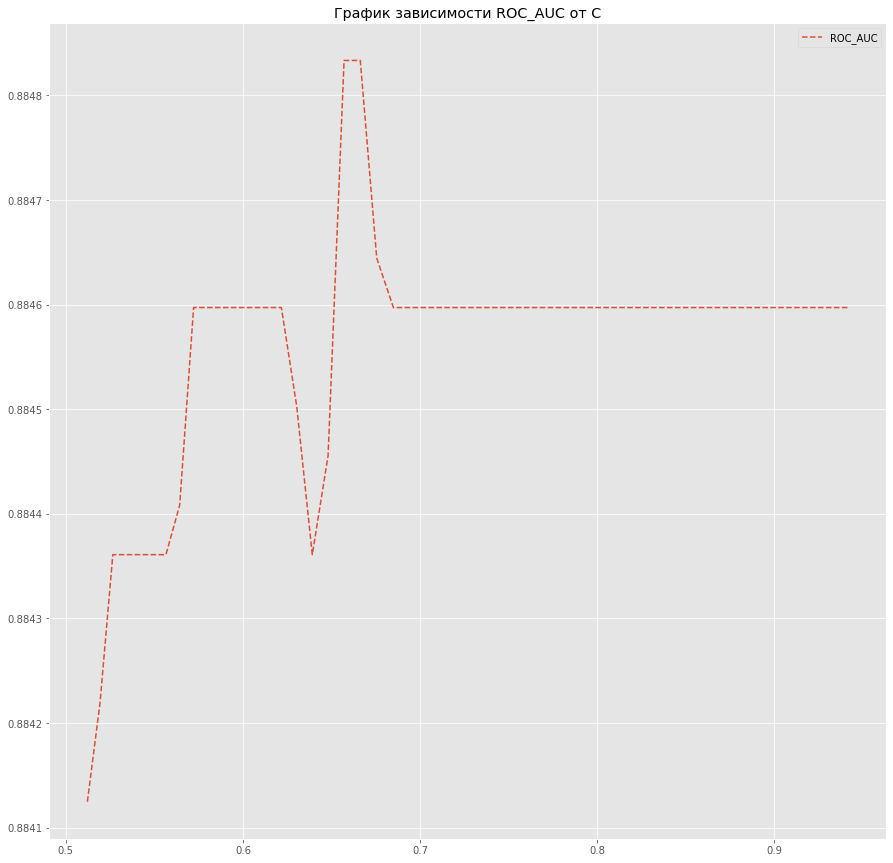

In [85]:
### YOUR CODE HERE ###

idx = Cs.tolist().index(lr.C_[0])

plt.figure(figsize=(15,15))
plt.plot(Cs[idx-40:idx+5], roc_auc[idx-40:idx+5], label='ROC_AUC', linestyle='--')
plt.legend()
plt.title('График зависимости ROC_AUC от C')
plt.show()

### 2.6
С помощью метода predict_proba получите вероятности принадлежности объектов тестовой выборки к классам. Постройте график roc_auc для тестовой выборки и выведите значение auc.

**Пример** построения графика.

In [75]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
probas = lr.fit(X_train, y_train).predict_proba(X_train)

Text(0, 0.5, 'tpr')

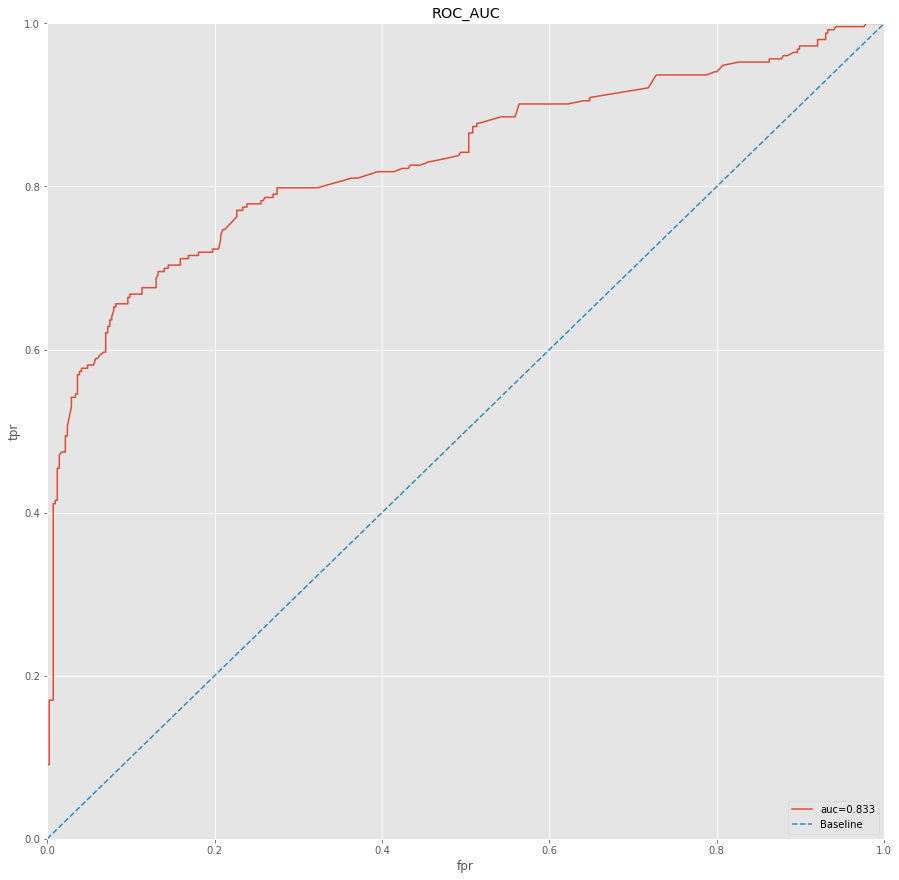

In [87]:
fpr, tpr, _ = roc_curve(y_train, probas[:, 1])
auc = roc_auc_score(y_train, probas[:, 1])
plt.figure(figsize=(15,15))
plt.plot(fpr, tpr, label="auc=" + str(round(auc, 3)))
plt.plot(np.linspace(0,1), np.linspace(0,1), linestyle='--', label='Baseline')
plt.legend(loc=4)
plt.title('ROC_AUC')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('fpr')
plt.ylabel('tpr')